In [1]:
!pip install openpyxl

import pandas as pd
import numpy as np
import os
from pathlib import Path
import openpyxl


✅ Loaded sample data: (2500, 66)


,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories,source_file
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,EnergieUebersichtCH-2021.xlsx
1,01.01.2021 00:15,1671630.088625,1210856.088,1880710.202024,635189.489912,869233.8751,17242,-2392,0,0,...,32685.315,27109.446,260040.413,20405.967,278109.595,97665.574,39143.313088,866.686,13374.112,EnergieUebersichtCH-2021.xlsx
2,01.01.2021 00:30,1661251.405625,1192987.411,1877758.191115,647088.60469,863927.1974,2639,-431,0,0,...,32658.413,24469.448,260521.051,20517.589,277796.491,97445.697,42522.34031,822.455,13178.706,EnergieUebersichtCH-2021.xlsx
3,01.01.2021 00:45,1641591.90225,1194179.748,1854953.225189,625842.285412,864593.4948,230,-574,0,0,...,32633.269,23613.422,257754.89,20614.251,273597.39,97301.079,39361.129588,615.664,12764.405,EnergieUebersichtCH-2021.xlsx
4,01.01.2021 01:00,1627956.774625,1188029.012,1847096.580761,621354.563153,857114.1599,126,-2521,0,0,...,31527.531,23336.463,255148.58,20454.126,269694.877,97292.006,41680.276847,618.147,12354.812,EnergieUebersichtCH-2021.xlsx


🔍 Candidates: ['Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock']
Final shape: (2495, 1)


,total_consumption_kWh
datetime,
2021-01-01 00:15:00,1.880710e+06
2021-01-01 00:30:00,1.877758e+06
2021-01-01 00:45:00,1.854953e+06
2021-01-01 01:00:00,1.847097e+06
2021-01-01 01:15:00,1.901830e+06


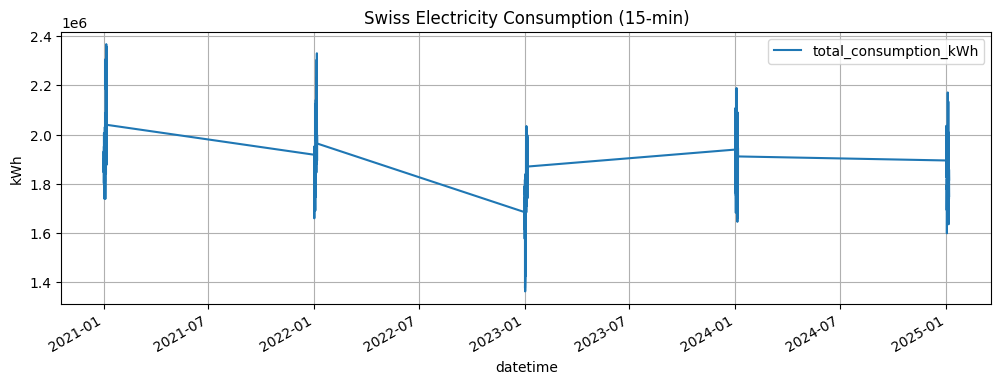

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# —————————————
# Step 0: Load sample (first 500 rows) from all Excel files
# —————————————
data_dir = Path("../data/raw")
files = sorted(data_dir.glob("EnergieUebersichtCH-*.xlsx"))
sheet_name = "Zeitreihen0h15"

dfs = []
for f in files:
    try:
        df = pd.read_excel(f, sheet_name=sheet_name, nrows=500)
        df["source_file"] = f.name
        dfs.append(df)
    except Exception as e:
        print(f" Error loading {f.name}: {e}")

sample_df = pd.concat(dfs, ignore_index=True)
print(f"✅ Loaded sample data: {sample_df.shape}")
display(sample_df.head())

# —————————————
# Step 1: Drop the “units” row (index 0) and rename the datetime column
# —————————————
df_clean = sample_df.drop(index=0).copy()
df_clean = df_clean.rename(columns={"Unnamed: 0": "datetime"})

# —————————————
# Step 2: Parse datetime and set as index
# —————————————
df_clean["datetime"] = pd.to_datetime(
    df_clean["datetime"],
    format="%d.%m.%Y %H:%M",
    errors="coerce"
)
df_clean = df_clean.dropna(subset=["datetime"]).set_index("datetime")

# —————————————
# Step 3: Drop the helper column if you don’t need it
# —————————————
# df_clean = df_clean.drop(columns=["source_file"])

# —————————————
# Step 4: Convert all remaining columns to numeric
# —————————————
for col in df_clean.columns:
    if col != "source_file":
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# —————————————
# Step 5: Identify your target column by partial match
# —————————————
partial = "Summe verbrauchte Energie Regelblock Schweiz"
candidates = [c for c in df_clean.columns if partial in c]
print("🔍 Candidates:", candidates)

# —————————————
# Step 6: Extract, clean, and plot
# —————————————
if candidates:
    col = candidates[0]
    df_focus = df_clean[[col]].dropna()
    df_focus = df_focus[df_focus[col] > 0]
    df_focus = df_focus.rename(columns={col: "total_consumption_kWh"})
    print(f"Final shape: {df_focus.shape}")
    display(df_focus.head())

    # Optional: Quick plot
    df_focus.plot(
        figsize=(12, 4),
        title="Swiss Electricity Consumption (15-min)"
    )
    plt.ylabel("kWh")
    plt.grid(True)
    plt.show()
else:
    print("Could not find the total consumption column.")


 Combined data shape: (157628, 65)
🔍 Candidates: ['Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock']
Total series shape: (157628, 1)


,total_consumption_kWh
datetime,
2021-01-01 00:15:00,1.880710e+06
2021-01-01 00:30:00,1.877758e+06
2021-01-01 00:45:00,1.854953e+06
2021-01-01 01:00:00,1.847097e+06
2021-01-01 01:15:00,1.901830e+06


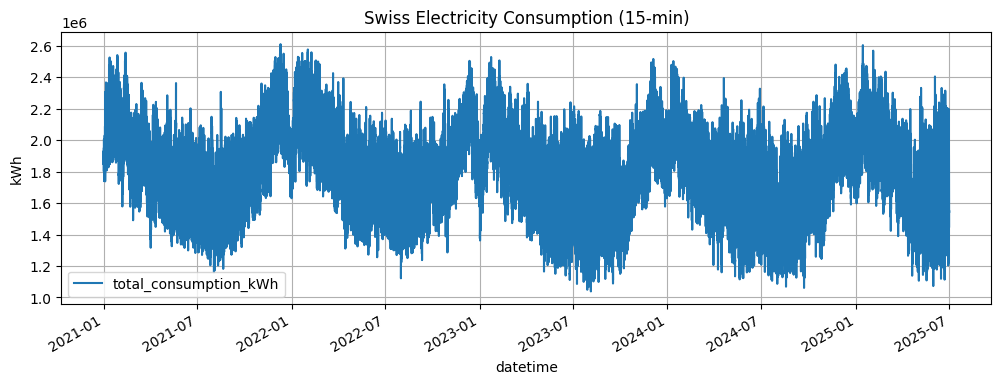

Saved to: ../data/processed/electricity_total_consumption_15min.csv


In [3]:

# —————————————
# 1. Setup
# —————————————

data_dir = Path("../data/raw")
files = sorted(data_dir.glob("EnergieUebersichtCH-*.xlsx"))
sheet_name = "Zeitreihen0h15"

# This will hold the cleaned DataFrame for each year
dfs_clean = []

# —————————————
# 2. Load & clean each file
# —————————————

for f in files:
    try:
        # Load entire sheet (header row = Excel row1)
        df = pd.read_excel(f, sheet_name=sheet_name)
        
        # Drop the “units” row (Excel row2 → df index 0)
        df_clean = df.drop(index=0).copy()
        
        # Rename the first column to "datetime"
        df_clean.rename(columns={df_clean.columns[0]: "datetime"}, inplace=True)
        
        # Parse and set datetime index
        df_clean["datetime"] = pd.to_datetime(
            df_clean["datetime"],
            format="%d.%m.%Y %H:%M",
            errors="coerce"
        )
        df_clean = df_clean.dropna(subset=["datetime"]).set_index("datetime")
        
        # Remove any duplicate columns
        df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
        
        # Convert all other columns to numeric
        for col in df_clean.columns:
            if col != "source_file":
                df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
        
        # Tag with source filename
        df_clean["source_file"] = f.name
        
        dfs_clean.append(df_clean)
    except Exception as e:
        print(f" Error processing {f.name}: {e}")

# —————————————
# 3. Concatenate all years into one DataFrame
# —————————————
df_all = pd.concat(dfs_clean)
df_all = df_all.sort_index()
print(f" Combined data shape: {df_all.shape}")

# —————————————
# 4. Extract Total Consumption column
# —————————————

partial = "Summe verbrauchte Energie Regelblock Schweiz"
candidates = [c for c in df_all.columns if partial in c]
print("🔍 Candidates:", candidates)

if candidates:
    total_col = candidates[0]
    df_total = df_all[[total_col]].dropna()
    df_total = df_total[df_total[total_col] > 0]
    df_total = df_total.rename(columns={total_col: "total_consumption_kWh"})
    
    print(f"Total series shape: {df_total.shape}")
    display(df_total.head())
    
    # Optional: plot the full series
    df_total.plot(
        figsize=(12, 4),
        title="Swiss Electricity Consumption (15-min)"
    )
    plt.ylabel("kWh")
    plt.grid(True)
    plt.show()
    
# —————————————
# 5. Save cleaned series
# —————————————

    out_dir = Path("../data/processed")
    out_dir.mkdir(parents=True, exist_ok=True)
    df_total.to_csv(out_dir / "electricity_total_consumption_15min.csv")
    print("Saved to:", out_dir / "electricity_total_consumption_15min.csv")
else:
    print("Could not find a matching total consumption column.")
